# Analysis of HOIs generated with a simple operation as multiplication or copy

In the following lines we reproduce a simple scenario in which we have 12 features, 6 of them presenting redundant/synergistic interdependencies with a target and 6 of them independent from the target. For instance in the case presented in this notebook, we have: 
 
 - a redundant/synergistic interaction between variables 0,1,2/6,7,8 and the target; 
 
 - a synergystic/redundant interaction within the multiplet of variables 3,4,5/9,10,11 that is independent from the target.

 We also generate the evolution of this interdependencies on a third dimension, following the shape of an hanning window.

In [6]:
import numpy as np
from numpy import random
import hoi
import matplotlib.pyplot as plt
#import xgi
from frites.utils import parallel_func

path="C:/Users/matte/Codes/"
path_results='C:/Users/matte/Codes/results/'
path_figures='C:/Users/matte/Codes/figures/'


from utils import *

In [26]:

#the target variable can be multivariate
target = random.multivariate_normal([0,0],[[1,0],[0,1]], 300).T
n_samples = 300
n_features = 12

data = np.zeros((n_features, n_samples))

data[0] =  random.normal(loc=0.0, scale=1.0, size=n_samples)
data[1] =  random.normal(loc=0.0, scale=1.0, size=n_samples)
data[2] =  random.normal(loc=0.0, scale=1.0, size=n_samples)

target[0] = (data[0] + data[1] + data[2])

data[3] =  random.normal(loc=0.0, scale=1.0, size=n_samples)
data[4] =  random.normal(loc=0.0, scale=1.0, size=n_samples)
data[5] = data[3] + data[4]

data[6] =  random.normal(loc=0.0, scale=1.0, size=n_samples) + target[1]
data[7] =  random.normal(loc=0.0, scale=1.0, size=n_samples) + target[1]
data[8] =  random.normal(loc=0.0, scale=1.0, size=n_samples) + target[1]


data[9] =  random.normal(loc=0.0, scale=1.0, size=n_samples)
data[10] =  random.normal(loc=0.0, scale=1.0, size=n_samples) + data[9]
data[11] = random.normal(loc=0.0, scale=1.0, size=n_samples) + data[9]

data = data.T

#Here we generate the evolution on a third dimension, that can be the imagined as the time in a neuroscientific framework.
n_variable = 100
variables=np.arange(100)

data_random=np.broadcast_to(np.random.multivariate_normal(np.zeros(n_features), np.identity(n_features), n_samples)[:,:,np.newaxis], (n_samples, n_features, n_variable))

#hanning windows that we used to model the evolution of the interdependencies on a third dim
han = np.broadcast_to(np.hanning(n_variable), (n_samples, n_features, n_variable))

data_features = np.broadcast_to(data[:,:,np.newaxis], (n_samples, n_features, n_variable))* han + (1-han) * data_random


## Computing and plotting (without any statistics)

In [27]:
minsize=2
maxsize=6

#Here we use the function defined in utils to "clean" the higher-order spreading
goinfo_proc=goinfo_create_fit_correction(data_features, target.T, minsize=minsize, maxsize=maxsize)


    Copnorm data
Get list of multiplets


  0%|          |  0/5 [00:00<?,       ?it/s]

    Copnorm data
Get list of multiplets


  0%|          |  0/5 [00:00<?,       ?it/s]

Get list of multiplets


Get list of multiplets


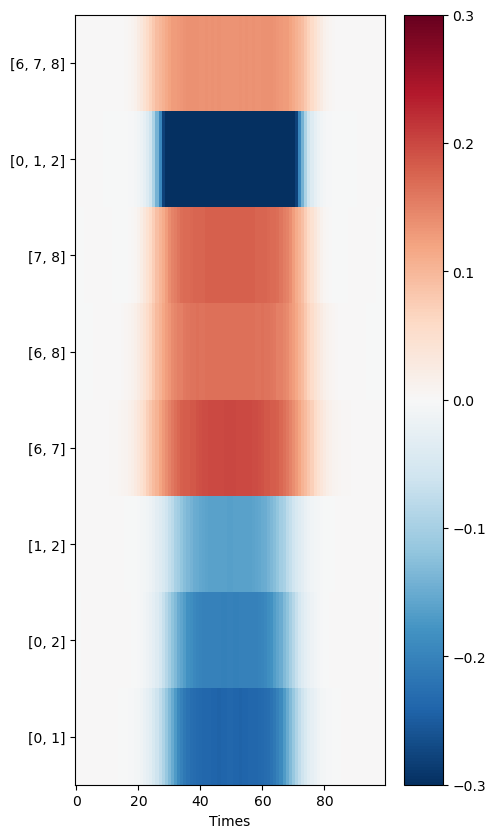

In [29]:
vmin, vmax = -.3,0.3

model=hoi.metrics.Oinfo(data_features, target.T)
combos=model.get_combinations(minsize=minsize, maxsize=maxsize)[0]
list_indices=[[int(c) for c in comb if c != -1] for comb in combos]
list_multiplets=[str([int(i) for i in comb]) for comb in list_indices]

# For this plot we only plot the most synergistic and redundant triplets
variables=np.arange(100)
plt.figure(figsize=(5,10))
index=np.where(np.sum(np.abs(goinfo_proc), axis=1)>1.5)[0]
plt.pcolormesh(
    variables, np.array([comb[:-9] + "]" for comb in list_multiplets])[index], goinfo_proc[index, :], cmap='RdBu_r', vmin=vmin, vmax=vmax
)

plt.colorbar()
plt.xlabel('Times')
plt.show()
plt.close()

In [32]:
minsize=2
maxsize=6

#Here we use the function defined in utils to "clean" the higher-order spreading
syn=synergyMMI_fit(data_features, target.T, minsize=minsize, maxsize=maxsize)


    Copnorm data
Get list of multiplets


  0%|          |  0/5 [00:00<?,       ?it/s]

Get list of multiplets


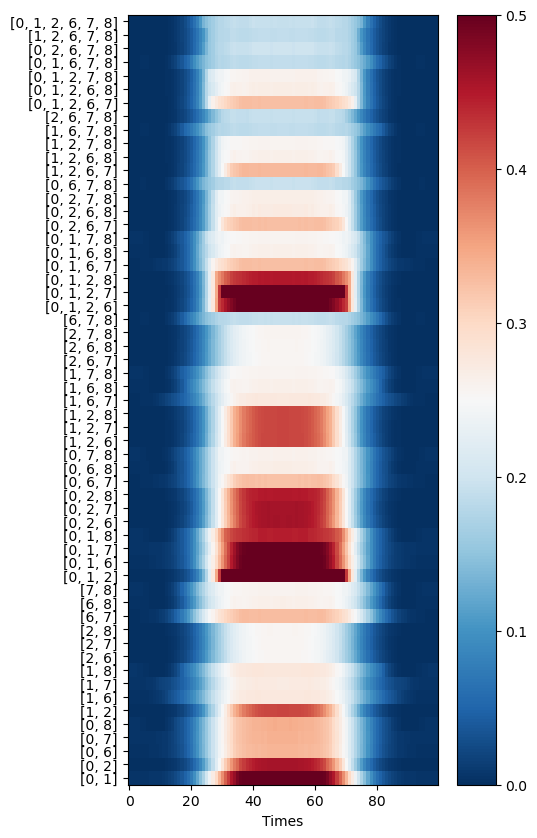

In [33]:
vmin, vmax = 0,0.5

model=hoi.metrics.Oinfo(data_features, target.T)
combos=model.get_combinations(minsize=minsize, maxsize=maxsize)[0]
list_indices=[[int(c) for c in comb if c != -1] for comb in combos]
list_multiplets=[str([int(i) for i in comb]) for comb in list_indices]

# For this plot we only plot the most synergistic and redundant triplets
variables=np.arange(100)
plt.figure(figsize=(5,10))
index=np.where(np.sum(np.abs(syn), axis=1)>1.5)[0]
plt.pcolormesh(
    variables, np.array([comb[:-9] + "]" for comb in list_multiplets])[index], syn[index, :], cmap='RdBu_r', vmin=vmin, vmax=vmax
)

plt.colorbar()
plt.xlabel('Times')
plt.show()
plt.close()

In [34]:
minsize=2
maxsize=6

#Here we use the function defined in utils to "clean" the higher-order spreading
red=redundancyMMI_fit(data_features, target.T, minsize=minsize, maxsize=maxsize)


    Copnorm data
Get list of multiplets


  0%|          |  0/5 [00:00<?,       ?it/s]

Get list of multiplets


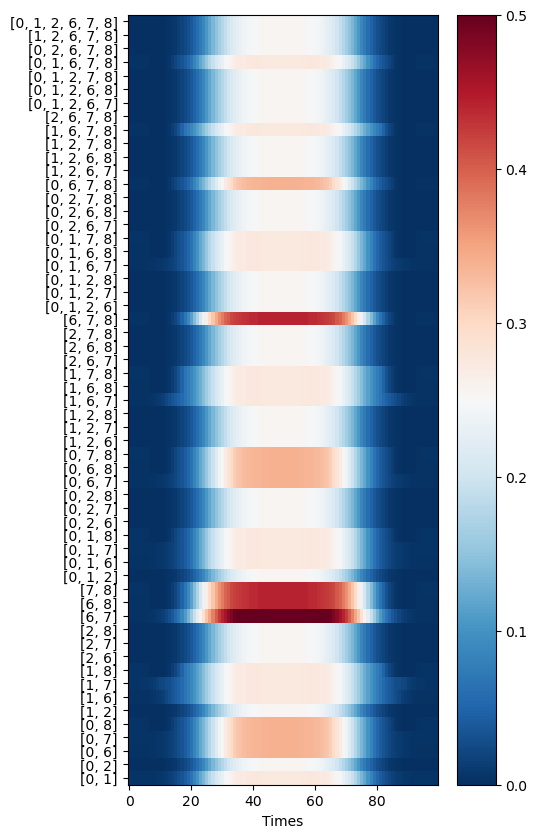

In [35]:
vmin, vmax = 0,0.5

model=hoi.metrics.Oinfo(data_features, target.T)
combos=model.get_combinations(minsize=minsize, maxsize=maxsize)[0]
list_indices=[[int(c) for c in comb if c != -1] for comb in combos]
list_multiplets=[str([int(i) for i in comb]) for comb in list_indices]

# For this plot we only plot the most synergistic and redundant triplets
variables=np.arange(100)
plt.figure(figsize=(5,10))
index=np.where(np.sum(np.abs(red), axis=1)>1.5)[0]
plt.pcolormesh(
    variables, np.array([comb[:-9] + "]" for comb in list_multiplets])[index], red[index, :], cmap='RdBu_r', vmin=vmin, vmax=vmax
)

plt.colorbar()
plt.xlabel('Times')
plt.show()
plt.close()

## Let's go with the permutations

In [37]:
n_perm=500
minsize=2
maxsize=5

parallel, p_fun = parallel_func(goinfo_create_fit_correction, n_jobs=-1, total=n_perm)

perm = parallel(p_fun(data_features, np.random.permutation(target.T), minsize=minsize, maxsize=maxsize) for n_p in range(n_perm))

perm=np.array(perm)

effect_list=[g[np.newaxis, i,:] for i in range(len(g[:,0]))]
perm_list=[perm[:,np.newaxis, i,:] for i in range(len(g[:,0]))]

inference='ffx'
mcp='cluster'

wf = WfStats()
pv, tv = wf.fit(effect_list, perm_list, inference=inference, mcp=mcp, tail=0)

  0%|          |  : 0/500 [00:00<?,       ?it/s]

In [ ]:
np.save( path_results+'goinfo_pvalues_simulations.npy', pv)
np.save( path_results+'goinfo_perm_simulations.npy', perm)
np.save(path_results+'goinfo_results.npy', goinfo_create_fit)

In [ ]:
goinfo_pv=np.load( path_results+'goinfo_pvalues_simulations.npy')
goinfo_perm=np.load( path_results+'goinfo_perm_simulations.npy')
goinfo=np.load(path_results+'goinfo_results.npy')

In [ ]:
n_perm=500
minsize=2
maxsize=5

parallel, p_fun = parallel_func(synergyMMI_fit, n_jobs=-1, total=n_perm)

perm = parallel(p_fun(data_features, np.random.permutation(target.T), minsize=minsize, maxsize=maxsize) for n_p in range(n_perm))

perm=np.array(perm)

effect_list=[g[np.newaxis, i,:] for i in range(len(g[:,0]))]
perm_list=[perm[:,np.newaxis, i,:] for i in range(len(g[:,0]))]

inference='ffx'
mcp='cluster'

wf = WfStats()
pv, tv = wf.fit(effect_list, perm_list, inference=inference, mcp=mcp, tail=0)

  0%|          |  : 0/500 [00:00<?,       ?it/s]

In [ ]:
np.save( path_results+'syn_pvalues_simulations.npy', pv)
np.save( path_results+'syn_perm_simulations.npy', perm)
np.save(path_results+'syn_results.npy', syn)

In [ ]:
syn_pv=np.load( path_results+'syn_pvalues_simulations.npy')
syn_perm=np.load( path_results+'syn_perm_simulations.npy')
syn=np.load(path_results+'syn_results.npy')

In [ ]:
n_perm=500
minsize=2
maxsize=5

parallel, p_fun = parallel_func(redundancyMMI_fit, n_jobs=-1, total=n_perm)

perm = parallel(p_fun(data_features, np.random.permutation(target.T), minsize=minsize, maxsize=maxsize) for n_p in range(n_perm))

perm=np.array(perm)

effect_list=[g[np.newaxis, i,:] for i in range(len(g[:,0]))]
perm_list=[perm[:,np.newaxis, i,:] for i in range(len(g[:,0]))]

inference='ffx'
mcp='cluster'

wf = WfStats()
pv, tv = wf.fit(effect_list, perm_list, inference=inference, mcp=mcp, tail=0)

  0%|          |  : 0/500 [00:00<?,       ?it/s]

In [ ]:
np.save( path_results+'red_pvalues_simulations.npy', pv)
np.save( path_results+'red_perm_simulations.npy', perm)
np.save(path_results+'red_results.npy', red)

In [ ]:
red_pv=np.load( path_results+'red_pvalues_simulations.npy')
red_perm=np.load( path_results+'red_perm_simulations.npy')
red=np.load(path_results+'red_results.npy')

# Some notes

## higher-order spreading ? 

It is possible to notice in this simple scenario that we can measure a strong value of O information (or gradient of O information between features and target O(target, features) - O(features) ) between n variables, also when one of this variable is independent from the others. For example we observe a strong synergy between variables (0,1,2,3,4), even if we know that 3 and 4 are statistically independent from the rest. 

## A better formulation of the problem, using the O-information

It is simple to prove that if avariable $X_i$ is independent from the others we have: $\Omega(X_1, ..., X_{i-1}, X_i) = \Omega(X_1, ..., X_{i-1})$. Now, if the variable {$X_1, ..., X_{i-1}$} are presenting a strong synergistic/redundant O-information, when we study {$X_1, ..., X_{i-1}, X_i$}, we will observe the same value of synergistic/redudant O-information. To not consider the fact that the submultiplet {$X_1, ..., X_{i-1}$} is explaining the O information of the multiplet {$X_1, ..., X_{i-1}, X_i$} may lead to think that there is some synergy among all the variables of the multiplet, that is not the case. 

## A possible way out

A possible way to a (possibly) more accurate formulation is the following: if we want to know that the synergy/redundancy of the multiplets {$X_1, ..., X_{i-1}, X_i$} is involving all the variables, i.e. it is not due to a submultiplets effect, we have to check that, if we exclude from the computation of O information $X_i$, we have the same effect (decrease of synergy/redundancy) as when excluding all the other variable $X_j, j\in\{1,2, ...,n\}$. 

For the following part we will consider: 
$ X^n = \{X_1, ..., X_{i-1}, X_{i},..., X_n\}$ and $ X^n_{-i} = \{X_1, ...,  X_{i-1}, X_{i+1}, ..., X_n\}$

In formulas we want to check that for each i, $\Omega(X^n)-\Omega(X^n_{-i}) <0 $ in the case of synergy, $>0$ in the case of redundancy. Then, if we are interested in the value of the genuine O information (i.e. not due to submultiplet), we can consider taking:

$$sign(\Omega(X^n)-\Omega(X^n_{-i}))*min_i(|\Omega(X^n)-\Omega(X^n_{-i})|) \ \ \ \ if \ \ \  \ |\sum_i^n sign(\Omega(X^n)-\Omega(X^n_{-i}))| = n$$

Another possibilities should be:

$$sign(\Omega(X^n)-\Omega(X^n_{-i})) * \prod_i(|\Omega(X^n)-\Omega(X^n_{-i})|) \ \ \ \ if \ \ \ \ |\sum_i^n sign(\Omega(X^n)-\Omega(X^n_{-i}))| = n$$

Where  $ X^n = \{X_1, ..., X_{i-1}, X_{i},..., X_n\}$ and $ X^n_{-i} = \{X_1, ...,  X_{i-1}, X_{i+1}, ..., X_n\}$

For the product, there is the problem that is vanishing ... 

All of this can be generalised to the gradient of O information, as used in the toolbox to investigate the relationship between features and target.





# creating the list for the permutation statistical test

 effect : list
    True effect list of length (n_roi,) composed of arrays each one of
    shape (n_subjects, ..., n_times). Number of subjects per ROI could
    be different

perms : list
    Permutation list of length (n_roi,) composed of arrays each one of
    shape (n_perm, n_subjects, ..., n_times). Number of subjects per
    ROI could be different

inference : {'ffx', 'irfx'}
    Perform either Fixed-effect ('ffx') or Random-effect ('rfx')
    inferences. By default, random-effect is used

mcp : {'cluster', 'maxstat', 'fdr', 'bonferroni', 'nostat', None}
    Method to use for correcting p-values for the multiple comparison
    problem. Use either : 